In [1]:
import numpy as np
import os
import re
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from tqdm import tqdm
tqdm.pandas()
import time
from hlsstack.hls_funcs.smooth import despike_ts, double_savgol
import gc
from glob import glob
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns

ERROR 1: PROJ: proj_create_from_database: Open of /project/cper_neon_aop/conda_envs/hls_nrt_env/share/proj failed


In [3]:
import sys
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/params/ffar_ok_params')
from ffar_ok_params_smooth import *

In [78]:
from importlib import reload
reload(sys.modules["ffar_ok_params_smooth"])
from ffar_ok_params_smooth import *

In [79]:
def adapt_smooth(ts, dates, despike=True, dat_thresh=None):
    ct_valid = sum(~np.isnan(ts))
    ct_total = len(ts)
    avg_gap = ct_total/ct_valid
    if ct_valid > 0:
        if avg_gap > 15:
            despike = False
        if despike:
            if dat_thresh is None:
                _dat_thresh = np.ptp(ts.values) * 0.10
            else:
                _dat_thresh = dat_thresh
            ts_ds = despike_ts(ts.values, dat_thresh=_dat_thresh, days_thresh=45)
        else:
            ts_ds = ts.values
        if avg_gap > 10:
            ts_smooth = double_savgol(ts_ds, double=True, window1_max=7, window2=31, limit=91)
        elif avg_gap > 7:
             ts_smooth = double_savgol(ts_ds, double=True, window1_max=5, window2=41, limit=91)
        elif avg_gap > 5:
             ts_smooth = double_savgol(ts_ds, double=True, window1_max=5, window2=51, limit=91)
        else:
            ts_smooth = double_savgol(ts_ds, double=False, window2=51, limit=91)
    else:
        ts_smooth = ts
    return pd.Series(ts_smooth, ts.index.get_level_values(-1))

In [80]:
fLIST = glob(inPATH_wc)
df = pd.read_csv(inPATH_dat, parse_dates=[date_col])

In [81]:
if preprocess is not None:
    df = preprocess(df)

In [82]:
df.head(5)

,Unnamed: 0,Block_name,Treatment,Date,Site,Ranch,Year,Low.reading_mean,Low.reading_sd,High.reading_mean,...,High.rounded_10_mean,High.rounded_10_sd,Sample_ID_vor,mean_biomass,sd_biomass,Sample_ID_bio,X_coord,Y_coord,ID,Block_Id
0,1,1,AD,2023-09-15,OK,CR,2023,33.103448,15.100484,65.137931,...,68.275862,16.490033,2023-09-15_OK_CR_AD_1,1299.600000,734.276242,2023-09-15_OK_CR_AD_1,-97.236883,33.935235,1_AD_2023,1_AD
1,2,1,AD,2023-08-17,OK,CR,2023,32.777778,16.220437,61.407407,...,64.814815,17.839104,2023-08-17_OK_CR_AD_1,2793.760000,1377.720337,2023-08-17_OK_CR_AD_1,-97.236883,33.935235,1_AD_2023,1_AD
2,3,1,AD,2022-07-19,OK,CR,2022,26.291667,12.425357,66.583333,...,69.166667,20.624314,2022-07-19_OK_CR_AD_1,3107.266667,1981.653183,2022-07-19_OK_CR_AD_1,-97.236883,33.935235,1_AD_2022,1_AD
3,4,1,AD,2023-06-22,OK,CR,2023,13.925926,15.733174,56.370370,...,59.259259,27.305385,2023-06-22_OK_CR_AD_1,2133.920000,1863.550963,2023-06-22_OK_CR_AD_1,-97.236883,33.935235,1_AD_2023,1_AD
4,5,1,AD,2022-10-12,OK,CR,2022,25.520000,14.643315,78.120000,...,79.600000,14.854853,2022-10-12_OK_CR_AD_1,4767.520000,724.500126,2022-10-12_OK_CR_AD_1,-97.236883,33.935235,1_AD_2022,1_AD


In [83]:
df_out = None

In [84]:
var_drop_list = [x for x in veg_list if x != 'NDVI'] + band_list

In [85]:
#veg_list = ['NDVI']
#band_list = []

In [86]:
for yr in df[date_col].dt.year.unique():
    print(yr)

    # get list of files that match year based on path
    fLIST_yr = [x for x in fLIST if str(yr) in os.path.basename(x).split('_')]

    # combine all individual tile files into one dataframe
    df_yr = pd.concat([pd.read_csv(x, parse_dates=[1]) for x in fLIST_yr])
    
    # rename columns to match ground data
    df_yr = df_yr.rename(columns={'time': date_col,
                                  'Plot': id_col})
    
    # convert date to datetime
    df_yr[date_col] = pd.to_datetime(df_yr[date_col])
    
    # remove all non-plot data
    #df_yr = df_yr[df_yr[id_col] != 'UNK']
    
    # remove any dates where bands are negative
    df_yr = df_yr[~((df_yr[band_list] < 0).any(axis=1))]

    # drop any duplicates by taking mean for each plot and date (might exist e.g., from plot on edge of tile during extraction)
    df_yr = df_yr.groupby([id_col, date_col]).mean().reset_index()
    
    # get missing dates for gap-filling
    dates_missing = [x for x in pd.date_range(df_yr[date_col].min(), df_yr[date_col].max()).date if x not in df_yr[date_col].dt.date.unique()]
    
    # convert missing dates to a dataframe for combining with veg index data
    df_missing = pd.DataFrame({
        id_col: list(chain.from_iterable([list(np.repeat(x, len(dates_missing))) for x in df_yr[id_col].unique()])),
        date_col: list(chain.from_iterable(dates_missing for x in df_yr[id_col].unique()))})
    
    df_missing[date_col] = pd.to_datetime(df_missing[date_col])
    
    # combine into one dataframe for gapfilling
    df_yr_ts = pd.concat([df_yr, df_missing]).sort_values([id_col, date_col])
    
    # apply Bolton mask to extracted values
    if mask_bolton_by_id:
        ps_bolton = df_yr_ts.groupby(id_col).progress_apply(lambda x: bolton_mask_np(x['BLUE'], x['SWIR2']))
        df_yr_ts.loc[df_yr_ts[ps_bolton.droplevel(0) == 1.0].index, list(veg_dict.keys()) + band_list] = np.nan
    
    # smooth all vegetation indices to gapfill
    print('Smoothing vegetation indices')
    for vegidx in tqdm(veg_list):
        #df_yr_ts[vegidx + '_smooth'] = df_yr_ts.groupby(id_col)[vegidx].transform(lambda x: double_savgol(x.values))
        vals_smooth_yr = df_yr_ts.groupby(id_col).apply(lambda x: adapt_smooth(x[vegidx], pd.to_datetime(x[date_col])))
        if vals_smooth_yr.index.nlevels > 1:
            df_yr_ts[vegidx + '_smooth'] = vals_smooth_yr.droplevel(list(np.arange(vals_smooth_yr.index.nlevels-1)))
        else:
            df_yr_ts[vegidx + '_smooth'] = vals_smooth_yr.values.squeeze()
    print('Smoothing individual bands')
    for band in tqdm(band_list):
        #df_yr_ts[band + '_smooth'] = df_yr_ts.groupby(id_col)[band].transform(lambda x: double_savgol(x.values))
        vals_smooth_yr = df_yr_ts.groupby(id_col).apply(lambda x: adapt_smooth(x[band], pd.to_datetime(x[date_col])))
        if vals_smooth_yr.index.nlevels > 1:
            df_yr_ts[band + '_smooth'] = vals_smooth_yr.droplevel(list(np.arange(vals_smooth_yr.index.nlevels-1)))
        else:
            df_yr_ts[band + '_smooth'] = vals_smooth_yr.values.squeeze()
    
    # create or append to final output
    if df_out is not None:
        # merge with existing ouptput dataset
        df_out = pd.concat([df_out, df_yr_ts])
    else:
        # create output dataset
        df_out = df_yr_ts.copy()

2023
Smoothing vegetation indices


100%|██████████| 22/22 [00:01<00:00, 12.64it/s]


Smoothing individual bands


100%|██████████| 6/6 [00:00<00:00, 14.81it/s]


2022
Smoothing vegetation indices


100%|██████████| 22/22 [00:01<00:00, 12.78it/s]


Smoothing individual bands


100%|██████████| 6/6 [00:00<00:00, 12.23it/s]


In [87]:
#df_out = df_out.drop(columns=var_drop_list)

In [88]:
df_out['ID_simp'] = df_out['ID'].apply(lambda x: '_'.join(x.split('_')[:-1]))
df_out['Year'] = df_out['Date'].dt.year

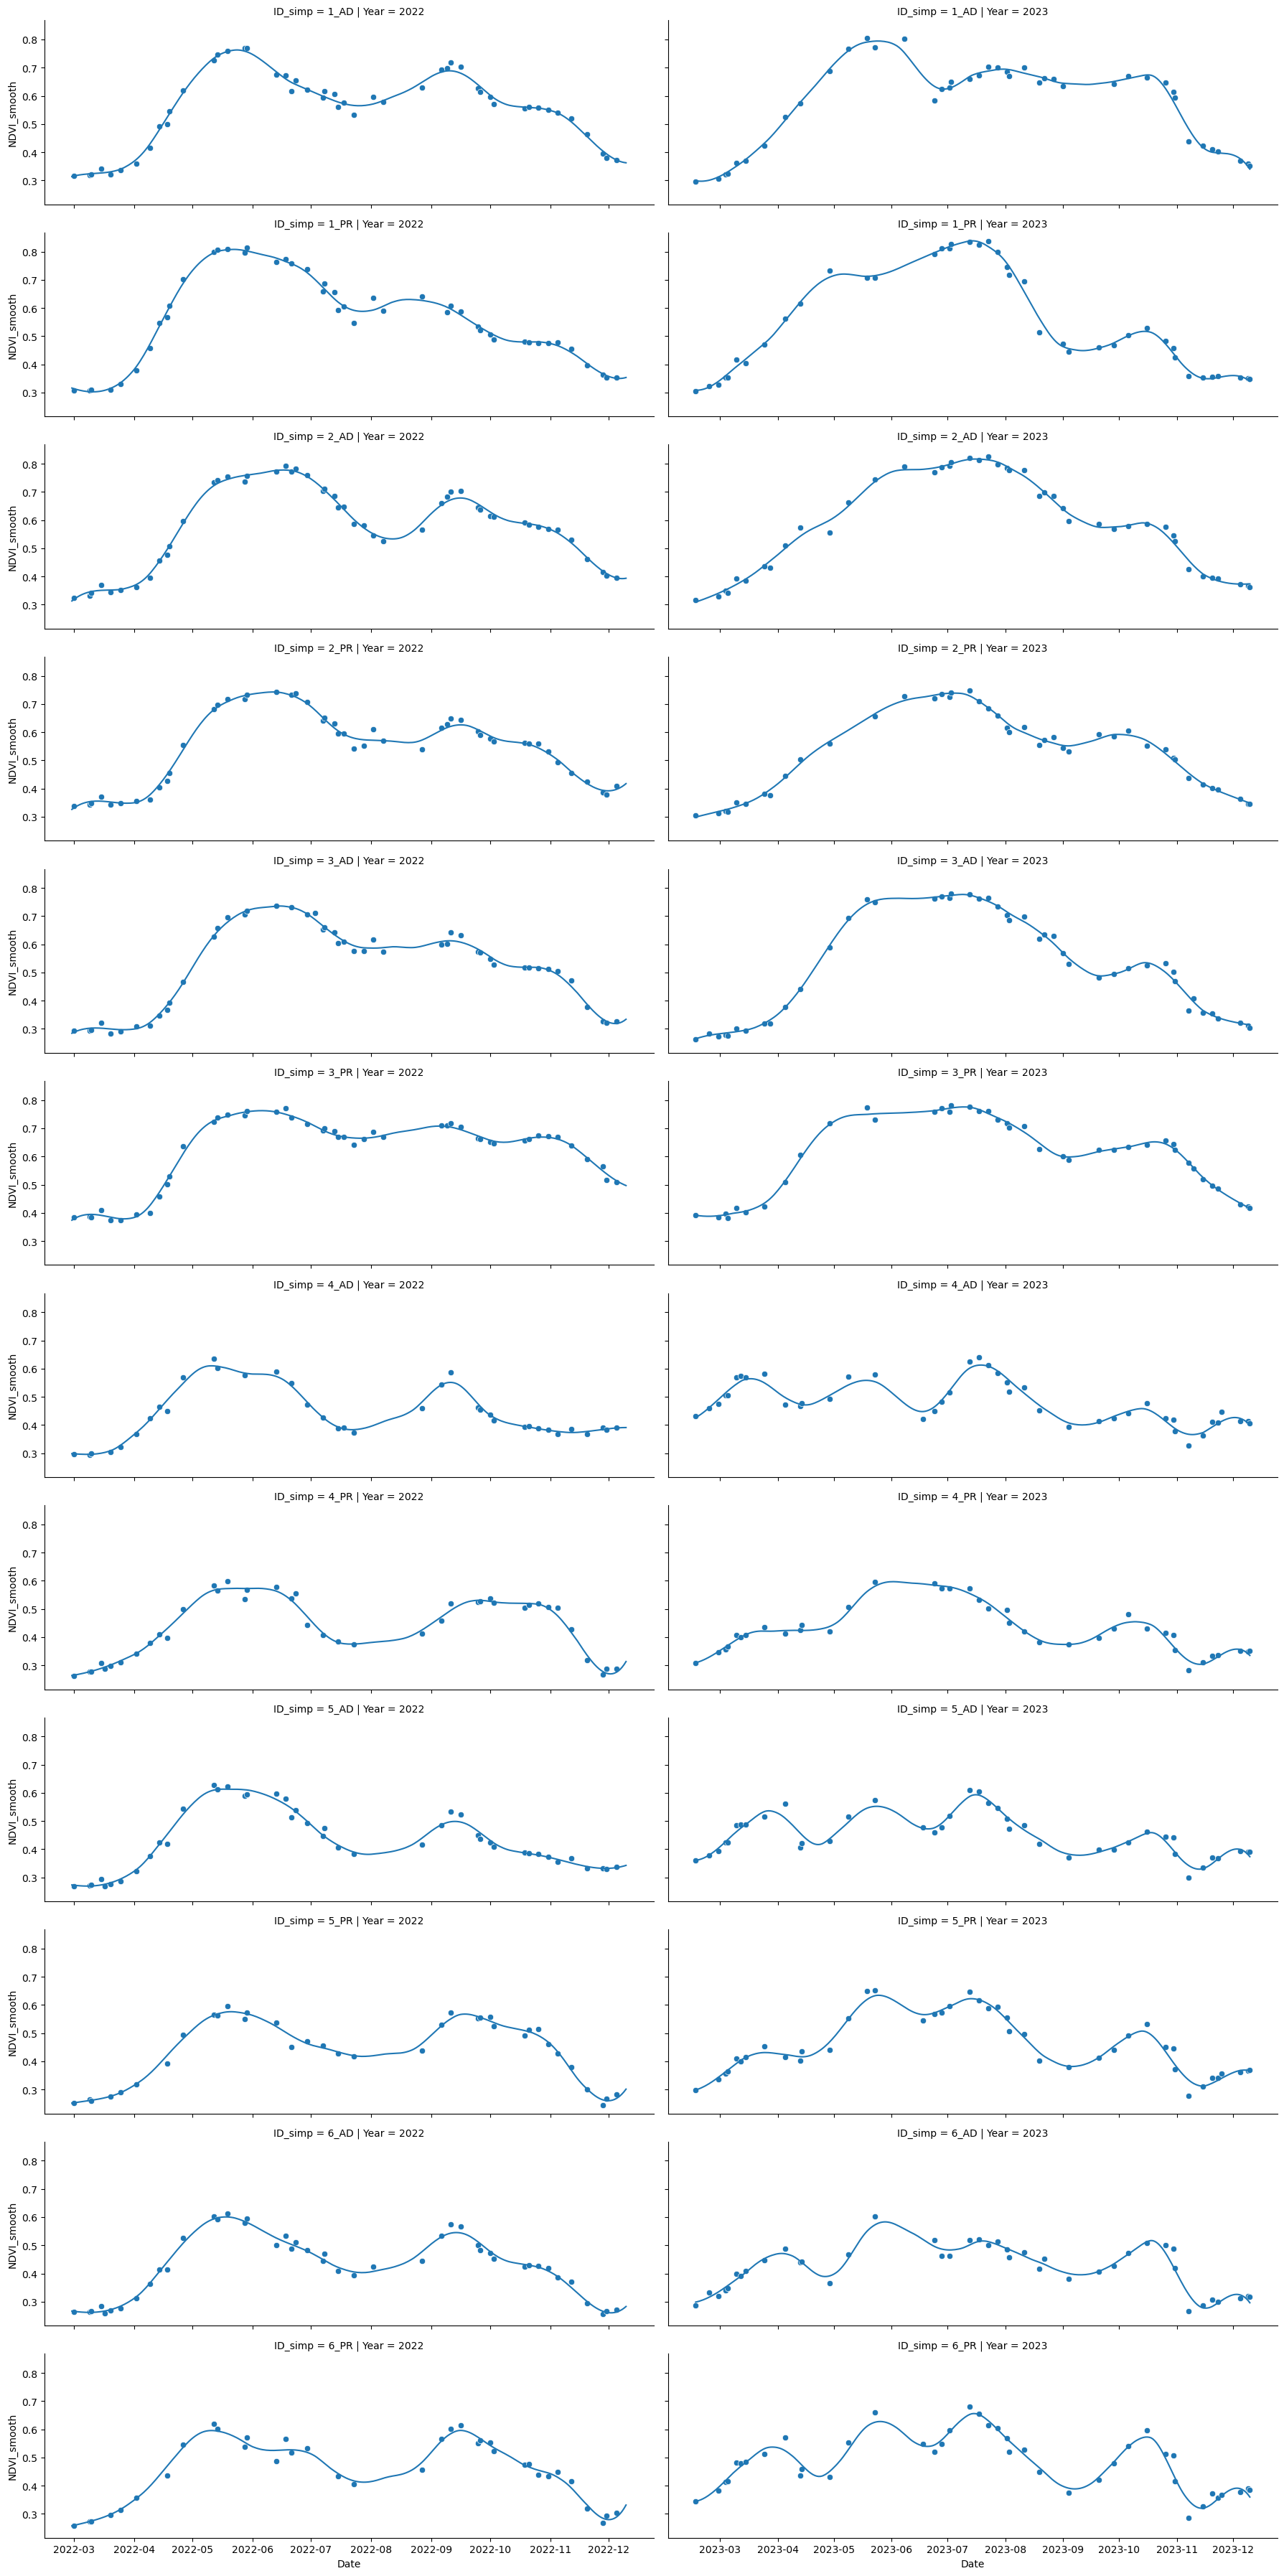

In [98]:
g = sns.FacetGrid(data=df_out, col='Year', row='ID_simp', sharex='col', height=3, aspect=3)
g.map(sns.scatterplot, 'Date', 'NDVI')
g.map(sns.lineplot, 'Date', 'NDVI_smooth')

In [93]:
df_out.drop(
    columns=var_drop_list + [x+'_smooth' for x in var_drop_list]).to_csv(
    'ffar_checks/ffar_ok_ndvi_timeseries_2022_2023.csv', index=False)

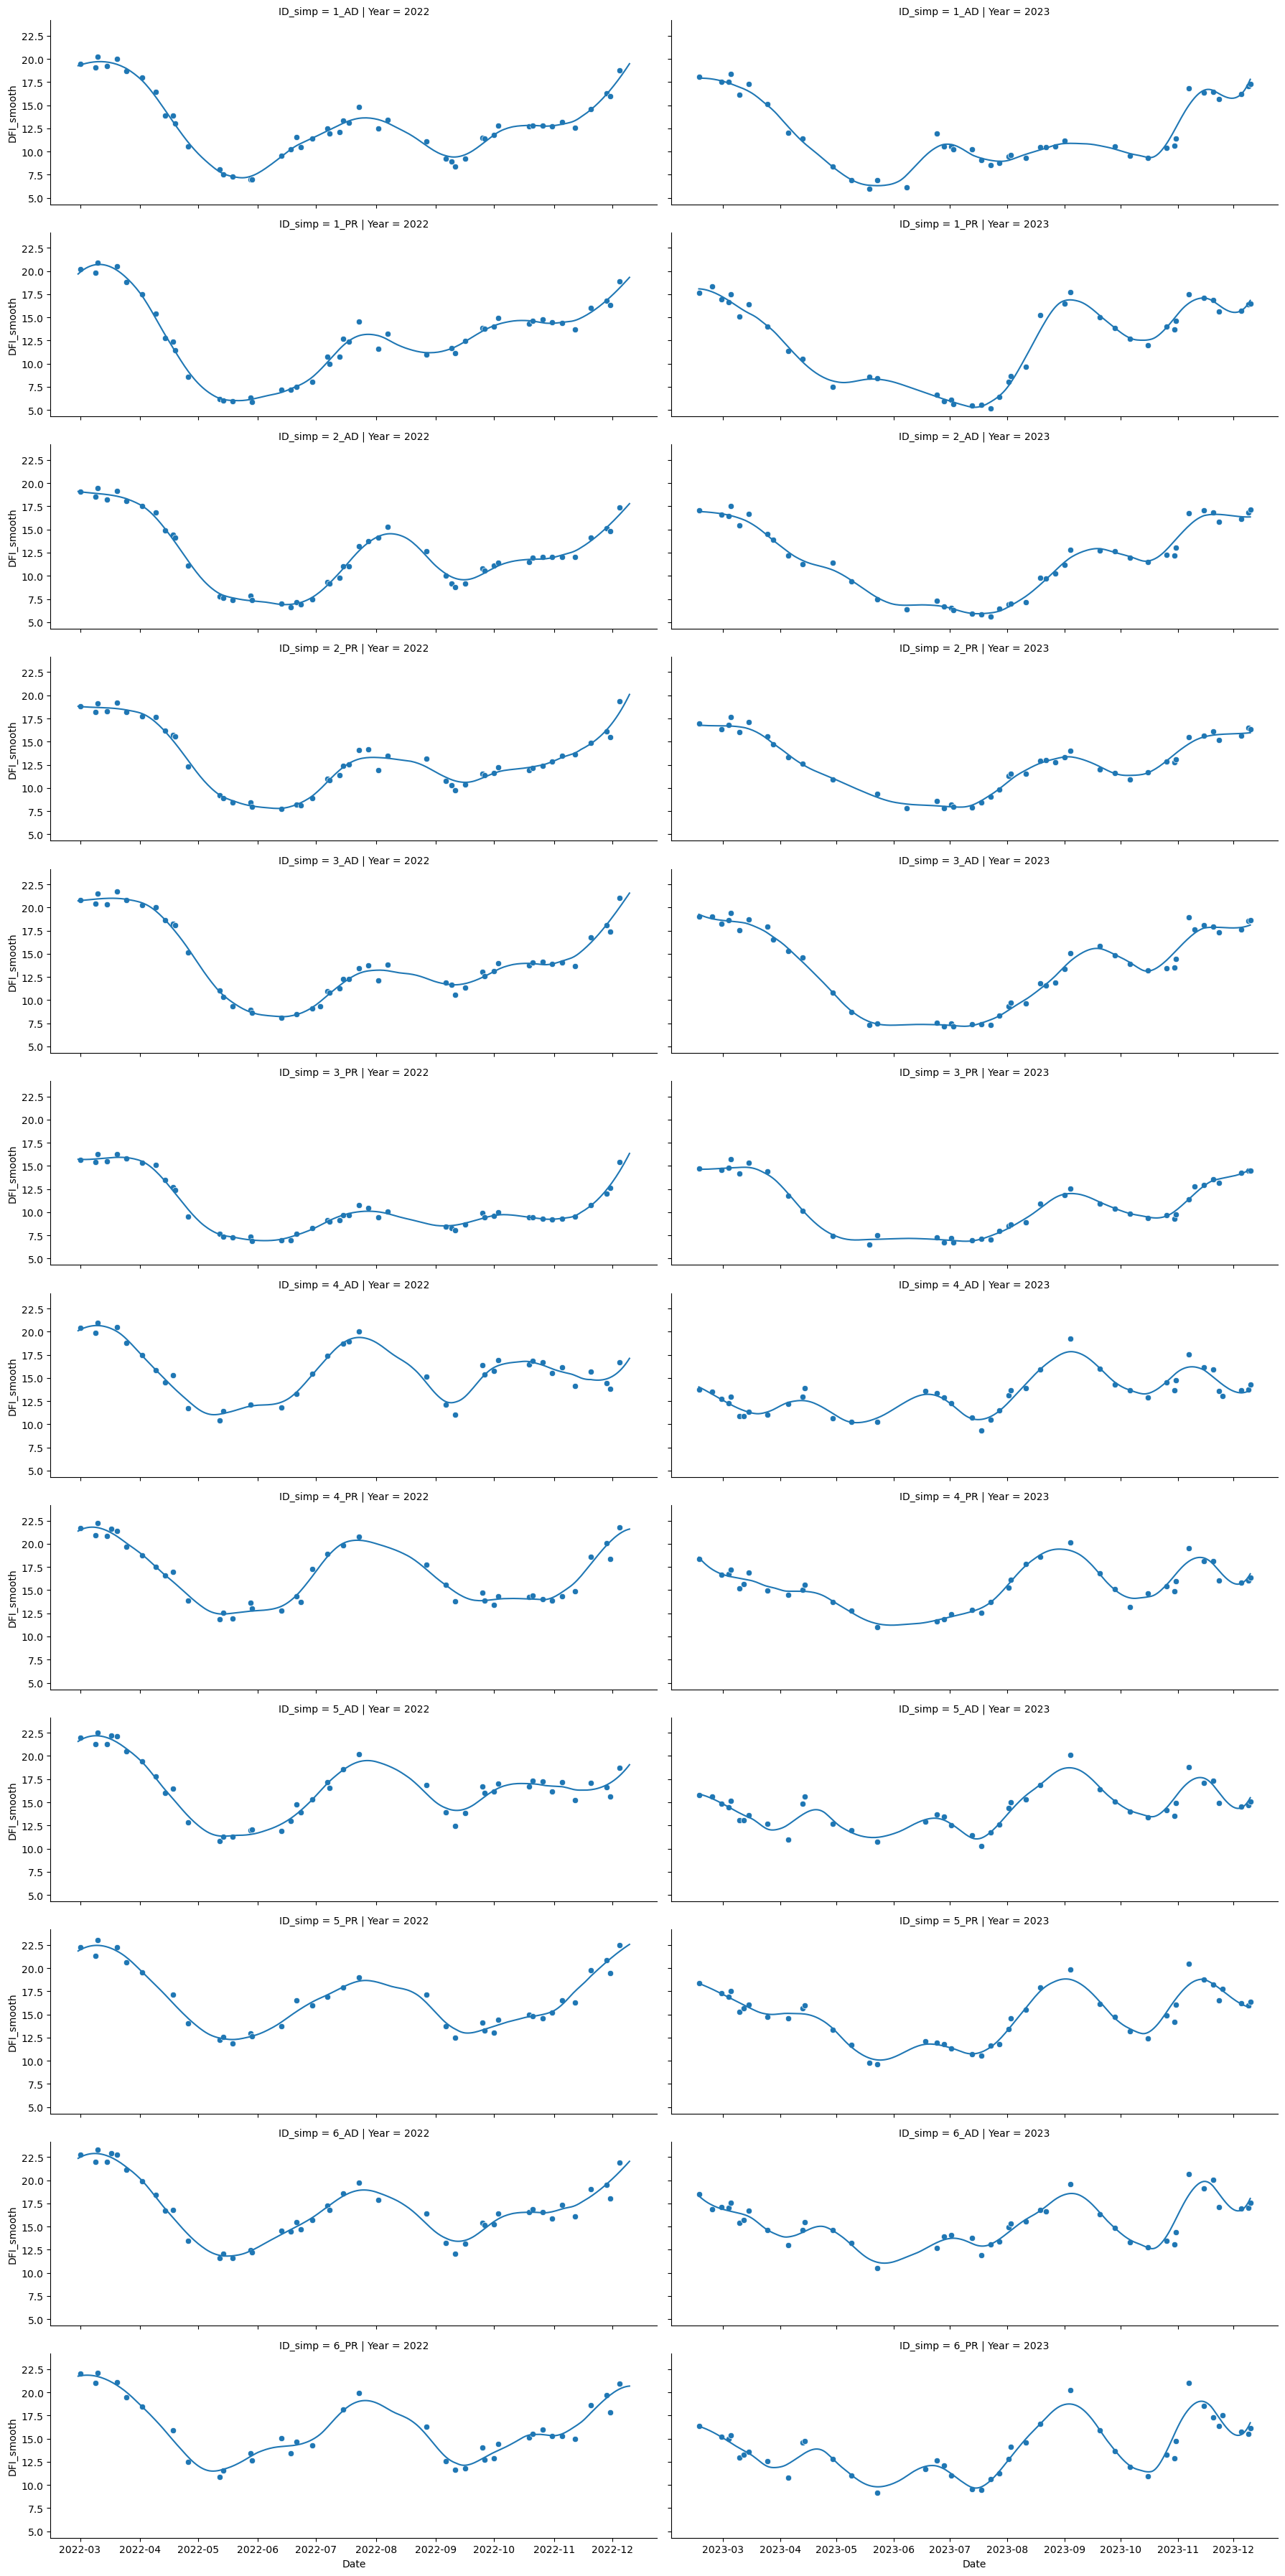

In [99]:
g = sns.FacetGrid(data=df_out, col='Year', row='ID_simp', sharex='col', height=3, aspect=3)
g.map(sns.scatterplot, 'Date', 'DFI')
g.map(sns.lineplot, 'Date', 'DFI_smooth')

In [95]:
df_out.to_csv(
    'ffar_checks/ffar_ok_all_timeseries_2022_2023.csv', index=False)